In [1]:
%load_ext autoreload
%autoreload 2 
%matplotlib inline

In [2]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt

In [3]:
aliases = pd.read_csv("hillary-clinton-emails/Aliases.csv", index_col=0)

In [4]:
emailReceivers = pd.read_csv("hillary-clinton-emails/EmailReceivers.csv", index_col=0)

In [5]:
persons = pd.read_csv("hillary-clinton-emails/Persons.csv", index_col=0)

In [6]:
emails = pd.read_csv("hillary-clinton-emails/Emails.csv", index_col=0)

In [7]:
emails.head(1)

,DocNumber,MetadataSubject,MetadataTo,MetadataFrom,SenderPersonId,MetadataDateSent,MetadataDateReleased,MetadataPdfLink,MetadataCaseNumber,MetadataDocumentClass,...,ExtractedTo,ExtractedFrom,ExtractedCc,ExtractedDateSent,ExtractedCaseNumber,ExtractedDocNumber,ExtractedDateReleased,ExtractedReleaseInPartOrFull,ExtractedBodyText,RawText
Id,,,,,,,,,,,,,,,,,,,,,
1,C05739545,WOW,H,"Sullivan, Jacob J",87.0,2012-09-12T04:00:00+00:00,2015-05-22T04:00:00+00:00,DOCUMENTS/HRC_Email_1_296/HRCH2/DOC_0C05739545...,F-2015-04841,HRC_Email_296,...,NaN,"Sullivan, Jacob J <Sullivan11@state.gov>",NaN,"Wednesday, September 12, 2012 10:16 AM",F-2015-04841,C05739545,05/13/2015,RELEASE IN FULL,NaN,UNCLASSIFIED\nU.S. Department of State\nCase N...


In [8]:
from wordcloud import WordCloud

In [9]:
email_full_texts = emails['ExtractedBodyText'].str.cat()

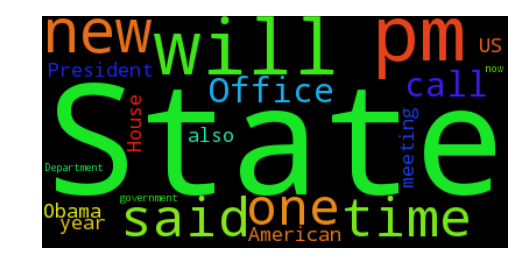

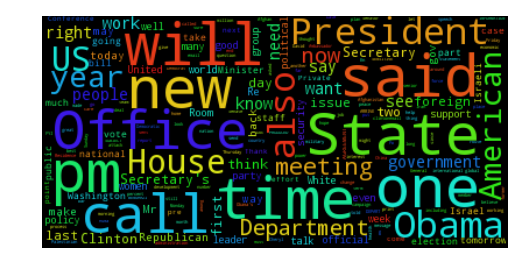

In [10]:
# Generate a word cloud image
wordcloud = WordCloud(max_words=20).generate(email_full_texts)

# Display the generated image:
# the matplotlib way:
plt.imshow(wordcloud)
plt.axis("off")

# lower max_font_size
wordcloud = WordCloud(max_font_size=50).generate(email_full_texts)
plt.figure()
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

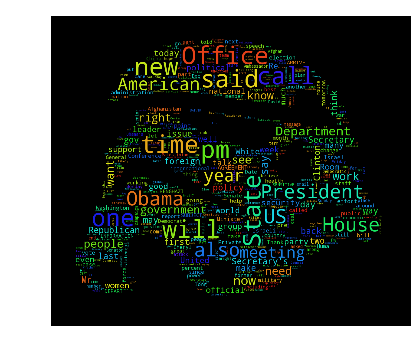

In [11]:
from os import path
from PIL import Image

stormtrooper_mask = np.array(Image.open(path.join(".", "stormtrooper_mask.png")))

#stopwords = set(STOPWORDS)
#stopwords.add("said")

wc = WordCloud(background_color="black", max_words=500, mask=stormtrooper_mask, max_font_size=80)
# generate word cloud
wc.generate(email_full_texts)

# store to file
wc.to_file(path.join(".", "stormtrooper_hillary_emails.png"))

# show
plt.imshow(wc)
plt.axis("off")
plt.figure()
#plt.imshow(stormtrooper_mask, cmap=plt.cm.gray)
#plt.axis("off")
plt.show()

### Text cleaning / massaging

In [12]:
email_bodies = emails['ExtractedBodyText']

In [13]:
email_bodies.isnull().sum()

1203

In [14]:
email_bodies.fillna("", inplace=True)

In [15]:
email_bodies.isnull().sum()

0

In [16]:
email_bodies[2]

'B6\nThursday, March 3, 2011 9:45 PM\nH: Latest How Syria is aiding Qaddafi and more... Sid\nhrc memo syria aiding libya 030311.docx; hrc memo syria aiding libya 030311.docx\nMarch 3, 2011\nFor: Hillary'

In [17]:
# First, remove the HTML tags or markup just in case.

# Import BeautifulSoup into your workspace
from bs4 import BeautifulSoup             

# Initialize the BeautifulSoup object on a single movie review     
example1 = BeautifulSoup(email_bodies[2], "lxml")  

# Print the raw review and then the output of get_text(), for 
# comparison
print(email_bodies[2])
print(example1.get_text())

B6
Thursday, March 3, 2011 9:45 PM
H: Latest How Syria is aiding Qaddafi and more... Sid
hrc memo syria aiding libya 030311.docx; hrc memo syria aiding libya 030311.docx
March 3, 2011
For: Hillary
B6
Thursday, March 3, 2011 9:45 PM
H: Latest How Syria is aiding Qaddafi and more... Sid
hrc memo syria aiding libya 030311.docx; hrc memo syria aiding libya 030311.docx
March 3, 2011
For: Hillary


In [18]:
import nltk
nltk.download()  # Download text data sets, including stop words

showing info https://raw.githubusercontent.com/nltk/nltk_data/gh-pages/index.xml


True

In [20]:
from nltk.corpus import stopwords # Import the stop word list
len(stopwords.words("english")) 

153

In [21]:
import re
def preprocess_email(email_body):
    # Function to convert a raw review to a string of words
    # The input is a single string (a raw movie review), and 
    # the output is a single string (a preprocessed movie review)
    #
    # 1. Remove HTML
    review_text = BeautifulSoup(email_body, "lxml").get_text() 
    #
    # 2. Remove non-letters        
    letters_only = re.sub("[^a-zA-Z]", " ", review_text) 
    #
    # 3. Convert to lower case, split into individual words
    words = letters_only.lower().split()                             
    #
    # 4. In Python, searching a set is much faster than searching
    #   a list, so convert the stop words to a set
    stops = set(stopwords.words("english"))                  
    # 
    # 5. Remove stop words and words with length 2 or less
    meaningful_words = [w for w in words if (not w in stops and len(w) > 2 )]
    #
    # 7. Stemming
    porter = nltk.SnowballStemmer('english')
    final_words = [porter.stem(t) for t in meaningful_words]
    #
    # 6.The WordNet lemmatizer only removes affixes if the resulting word is in its dictionary
    #wnl = nltk.WordNetLemmatizer()
    #lemm_words = [wnl.lemmatize(t) for t in final_words]
    
    # 8. Join the words back into one string separated by space, 
    # and return the result.
    return( " ".join(final_words)) 

In [123]:
email_bodies = email_bodies.map(preprocess_email)

In [124]:
email_bodies[2]

'thursday march latest syria aid qaddafi sid hrc memo syria aid libya docx hrc memo syria aid libya docx march hillari'

In [125]:
cleaned_email_full_texts = email_bodies.str.cat()

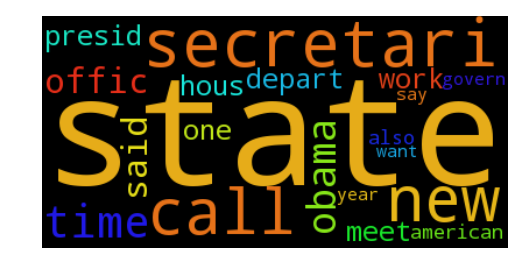

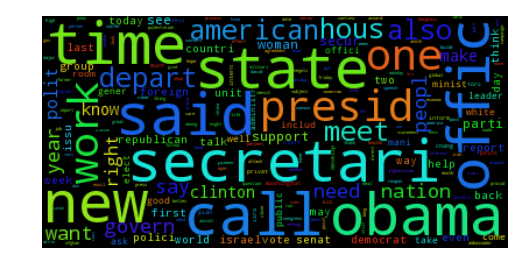

In [126]:
# Generate a word cloud image
wordcloud = WordCloud(max_words=20).generate(cleaned_email_full_texts)

# Display the generated image:
# the matplotlib way:
plt.imshow(wordcloud)
plt.axis("off")

# lower max_font_size
wordcloud = WordCloud(max_font_size=50).generate(cleaned_email_full_texts)
plt.figure()
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

### 3. Topic Modelling

In [127]:
import gensim

In [128]:
def get_corpus(texts):
    corpusH = [x.split() for x in texts]
    return corpusH

In [129]:
corpusH = get_corpus(list(email_bodies))

In [130]:
dictionary = gensim.corpora.Dictionary(corpusH)
tokenizedCorpus = [dictionary.doc2bow(text) for text in corpusH]
lda = gensim.models.ldamodel.LdaModel(corpus=tokenizedCorpus,  num_topics=25, id2word = dictionary)

In [131]:
lda.print_topics(25)

[(0,
  '0.040*"call" + 0.022*"get" + 0.019*"work" + 0.014*"email" + 0.012*"back" + 0.011*"thank" + 0.011*"want" + 0.010*"jake" + 0.010*"send" + 0.010*"also"'),
 (1,
  '0.017*"bank" + 0.012*"bibi" + 0.009*"abba" + 0.009*"make" + 0.009*"china" + 0.009*"lissa" + 0.008*"ashton" + 0.008*"get" + 0.008*"would" + 0.007*"polici"'),
 (2,
  '0.019*"state" + 0.015*"sent" + 0.015*"sullivan" + 0.015*"huma" + 0.015*"via" + 0.013*"abedin" + 0.013*"blackberri" + 0.013*"depart" + 0.012*"cheryl" + 0.012*"ann"'),
 (3,
  '0.010*"mcchrystal" + 0.010*"israel" + 0.009*"isra" + 0.008*"would" + 0.007*"say" + 0.005*"settlement" + 0.005*"govern" + 0.005*"presid" + 0.005*"war" + 0.005*"torus"'),
 (4,
  '0.027*"state" + 0.026*"print" + 0.022*"gov" + 0.011*"call" + 0.010*"mail" + 0.010*"receiv" + 0.008*"messag" + 0.008*"want" + 0.008*"monday" + 0.007*"check"'),
 (5,
  '0.011*"know" + 0.011*"would" + 0.009*"like" + 0.007*"tomorrow" + 0.006*"work" + 0.006*"day" + 0.006*"said" + 0.006*"thank" + 0.006*"call" + 0.006*"ti

### BONUS: communication graph

In [22]:
# remove nan sender id's
senders = emails[emails['SenderPersonId'].isnull() == False]

In [23]:
senders['SenderPersonId'].isnull().sum()

0

In [24]:
senders_receivers = pd.merge(emailReceivers, senders[['SenderPersonId','DocNumber']], left_on='EmailId', right_index='true', how='inner')

In [25]:
senders_receivers.drop('DocNumber', axis=1, inplace=True)

In [26]:
senders_receivers.rename(columns={'PersonId': 'ReceiverId', 'SenderPersonId': 'SenderId'}, inplace=True)

In [27]:
senders_receivers['SenderId'] = senders_receivers['SenderId'].astype(int)

In [28]:
senders_receivers

,EmailId,ReceiverId,SenderId
Id,,,
1,1,80,87
3,3,228,32
4,3,80,32
5,4,80,32
6,5,81,80
7,6,185,80
8,7,80,32
9,8,81,80
10,9,80,87


In [30]:
import community
import networkx as nx

In [31]:
G = nx.from_pandas_dataframe(senders_receivers, 'ReceiverId', 'SenderId')

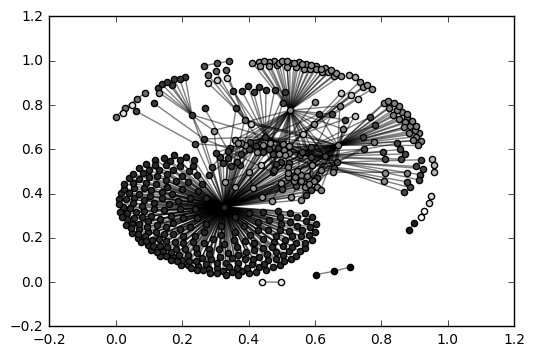

In [33]:
#first compute the best partition
partition = community.best_partition(G)

#drawing
size = float(len(set(partition.values())))
pos = nx.spring_layout(G)
count = 0.
for com in set(partition.values()) :
    count = count + 1.
    list_nodes = [nodes for nodes in partition.keys()
                                if partition[nodes] == com]
    nx.draw_networkx_nodes(G, pos, list_nodes, node_size = 20,
                                node_color = str(count / size))


nx.draw_networkx_edges(G, pos, alpha=0.5)
plt.show()

In [35]:
partition

{4: 0,
 5: 1,
 7: 2,
 9: 3,
 10: 4,
 11: 2,
 12: 4,
 13: 2,
 14: 5,
 15: 2,
 16: 6,
 17: 7,
 19: 6,
 20: 2,
 21: 8,
 22: 9,
 23: 4,
 24: 2,
 25: 2,
 29: 7,
 30: 2,
 31: 1,
 32: 9,
 34: 2,
 35: 9,
 37: 2,
 38: 9,
 39: 2,
 40: 2,
 41: 3,
 42: 3,
 44: 2,
 45: 2,
 46: 8,
 47: 5,
 48: 10,
 49: 2,
 50: 2,
 52: 2,
 53: 4,
 54: 2,
 55: 11,
 56: 2,
 57: 4,
 58: 8,
 59: 9,
 60: 4,
 63: 3,
 65: 2,
 66: 2,
 70: 9,
 72: 2,
 73: 2,
 74: 12,
 75: 12,
 76: 2,
 77: 3,
 80: 2,
 81: 8,
 85: 2,
 86: 4,
 87: 3,
 88: 5,
 89: 2,
 90: 3,
 91: 2,
 92: 9,
 93: 3,
 94: 3,
 95: 3,
 97: 9,
 98: 2,
 99: 9,
 100: 2,
 101: 2,
 102: 2,
 103: 10,
 105: 4,
 106: 8,
 107: 13,
 108: 14,
 109: 15,
 110: 2,
 111: 2,
 112: 10,
 113: 3,
 115: 9,
 116: 13,
 117: 8,
 118: 15,
 119: 2,
 120: 2,
 121: 2,
 122: 8,
 123: 2,
 124: 9,
 125: 11,
 127: 9,
 128: 2,
 129: 8,
 130: 2,
 131: 2,
 132: 2,
 133: 4,
 134: 8,
 135: 4,
 137: 8,
 138: 10,
 139: 10,
 140: 9,
 141: 2,
 142: 3,
 143: 4,
 144: 10,
 145: 4,
 146: 9,
 147: 2,
 148: 2,
